In [1]:
import io
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal, stats
from glob import glob
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

## Functions

In [5]:
# need to make a function that chooses stim event times
def get_stim_events(stim_table, stim_type, stim_param, sweep):

    if np.isin('stim_parameter', stim_table.columns):
        return stim_table[
                (stim_table['stim_type'] == stim_type) &
                (stim_table['stim_parameter'] == stim_param) &
                (stim_table['sweep'] == sweep)
                ].onset.values
    elif np.isin('amplitude', stim_table.columns):
        return stim_table[
                (stim_table['stim_type'] == stim_type) &
                (stim_table['amplitude'] == stim_param) &
                (stim_table['sweep'] == sweep)
                ].onset.values

In [6]:
# get event triggered firing rates
def get_evoked_EEG(EEG_data, timestamps, events, plot_before, plot_after, data_sample_rate):
    dpts = int((plot_after + plot_before) * data_sample_rate)
    timex = np.linspace(-plot_before, plot_after, dpts)*1000 # puts time axis in ms
    
    evoked_traces = np.zeros((dpts, np.shape(EEG_data)[1], len(events)))
    for j, jtime in enumerate(events):
        fromind = np.where((timestamps >= jtime - plot_before) & (timestamps <= jtime + plot_after))[0][0]
        chinds = np.arange(fromind, fromind+dpts)
        evoked_traces[:,:,j] = EEG_data[chinds,:]
    
    return evoked_traces, timex

## Load experiment instance

In [7]:
# dfolder = r'F:\EEG_exp\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1'
dfolder = r'F:\EEG_exp\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1'
# load experiment metadata and eeg data
exp = EEGexp(dfolder, preprocess=False)

Experiment type: electrical stimulation.
SomnoSuite log file not found.


In [8]:
print(exp.ephys_params['EEG']['sample_rate'])
print(exp.ephys_params['EEG']['num_chs'])

2500
40


### Load EEG data and adjusted stimulus log

In [9]:
eeg_data, eeg_ts = exp.load_eegdata()

In [10]:
print(eeg_data.shape)
print(eeg_ts.shape)

(10727680, 32)
(10727680,)


In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,amplitude,duration,onset,offset,sweep
0,biphasic,70,400.0,130.842280,130.84299,0
1,biphasic,70,400.0,134.439439,134.44025,0
2,biphasic,70,400.0,138.758008,138.75891,0
3,biphasic,70,400.0,143.075967,143.07698,0
4,biphasic,70,400.0,147.298836,147.29994,0


### Plot raw trace from one channel to look at artifact

In [14]:
cha = 9
cha_eeg = eeg_data[:, cha]

chb = 0
chb_eeg = eeg_data[:, chb]

<IPython.core.display.Javascript object>


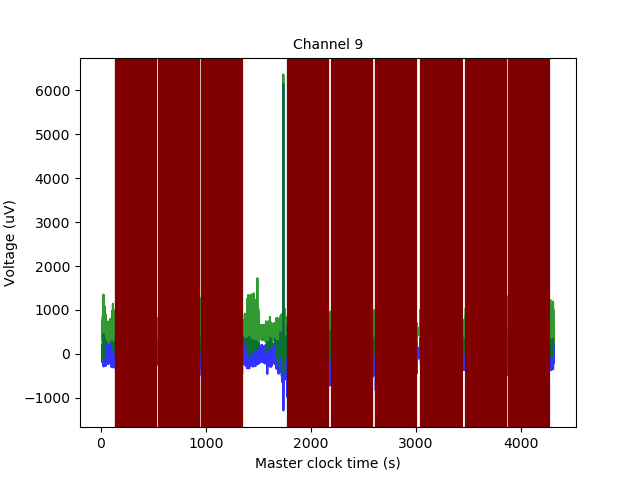

Text(0.5, 1.0, 'Channel 9')

In [16]:
fig, ax = plt.subplots()

ax.plot(eeg_ts, cha_eeg, 'b', alpha=0.8)
ax.plot(eeg_ts, chb_eeg+500, 'g', alpha=0.8)
for i, row in stim_log.iterrows():
    if row.amplitude == 20:
        lc = 'plum'
    elif row.amplitude == 50:
        lc = 'orange'
    elif row.amplitude == 70:
        lc = 'maroon'
    ax.axvline(row.onset, color=lc, linewidth=0.8)
    
ax.set_ylabel('Voltage (uV)')
ax.set_xlabel('Master clock time (s)')
ax.set_title('Channel %d' % cha)

In [18]:
1/0.03

33.333333333333336

### Take a look at the instructions for the stimulator

### Adjust sync onset/offset issue with 521887 and 543393
Onset shift is due to the sync pulse being 100 us longer than the stim pulse (we did this for the fast-settle function, but it did not help). It means that the very first stim instruction is sent simultaneous with the sync pulse, but every subsequent sync pulse is sent 100 us * pulse number later than the stim.